In [1]:
import cv2 as cv
import numpy as np
import random as rng

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def in_order(pts):
    # make an array of vectors starting from v0
    #  so.. arr[0..3] = [v01, v02, v03]
        
    # compute cross product of vec02 X vec01
    cross21 = np.cross(pts[2], pts[1])
    
    # compute cross product of vec02 X vec04
    cross24 = np.cross(pts[2], pts[3])
    
    print("cross21: ", cross21)
    print("cross24: ", cross24)
    
    if (cross21 > 0 and cross24 < 0): 
        return True
    else:
        return False

def order_points(pts):

    opt1 = pts
    opt2 = [pts[0], pts[2], pts[1], pts[3]]
    opt3 = [pts[0], pts[1], pts[3], pts[2]]
        
    if (in_order(opt1)):
        ordering = opt1
    elif (in_order(opt2)):
        ordering = opt2
    elif (in_order(opt3)):
        ordering = opt3
    else:
        print("ERROR PUTTING POINTS IN ORDER")
        exit(-1)
        
    rect = np.zeros((4,2), dtype="float32")
    
    rect[0] = ordering[0]
    rect[1] = ordering[1]
    rect[2] = ordering[2]
    rect[3] = ordering[3]
    
    return rect

In [3]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0,0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    M = cv.getPerspectiveTransform(rect, dst)
    warped = cv.warpPerspective(image, M, (maxWidth, maxHeight))
        
    return warped

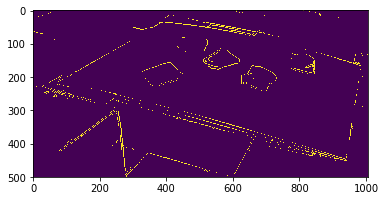

In [4]:
# Find edges

import imutils

src = cv.imread('images/srcimg.png')
ratio = src.shape[0] / 500.0 # will help project original, not scaled image
orig = src.copy()
src = imutils.resize(src, height=500)

gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
gray = cv.GaussianBlur(gray, (5,5), 0)
edged = cv.Canny(gray, 75, 200)

plt.imshow(src)
plt.imshow(edged)

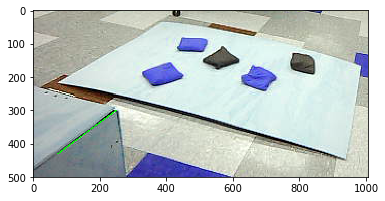

In [5]:
# Find contours and only keep largest ones
cnts = cv.findContours(edged.copy(), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnts = sorted(cnts, key = cv.contourArea, reverse = True)[:5]

for c in cnts:
    # approximate the contour
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.02 * peri, True)
    
    if len(approx == 4):
        screenCnt = approx
        break
        
cv.drawContours(src, [screenCnt], -1, (0, 255, 0), 2)
plt.imshow(src)

In [6]:
# apply the transform to get the top-down view

warped = four_point_transform(orig, screenCnt.reshape(4,2) * ratio)



ValueError: cannot reshape array of size 4 into shape (4,2)

In [ ]:
from scipy import ndimage

proj_rot90 = ndimage.rotate(warped, -90)
proj_rot90 = np.fliplr(proj_rot90)

plt.figure()
plt.imshow(cv.cvtColor(src, cv.COLOR_BGR2RGB))
plt.figure()
plt.imshow(cv.cvtColor(proj_rot90, cv.COLOR_BGR2RGB))


In [ ]:
img = cv.cvtColor(proj_rot90, cv.COLOR_BGR2GRAY)

# Setup SimpleBlobDetector parameters
params = cv.SimpleBlobDetector_Params()

params.minThreshold = 10
params.maxThreshold = 200

params.filterByArea = True
params.minArea = 100

#params.filterByInertia = True
#params.minInertia = 0

# Create blob detector with default params
blob_detector = cv.SimpleBlobDetector_create(params)

# Detect blobs
blobs = blob_detector.detect(img)

# Draw blobs as red circles
img_with_blobs_outlined = cv.drawKeypoints(img, blobs, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show the keypoints
plt.imshow(img_with_blobs_outlined)